# Correct Bleaching in bongwoori dataset

### Import libraries 

In [2]:
# libraries
from tifffile import TiffFile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from thunder import Colorize
import seaborn as sns
import fit
import cv2
from scipy.optimize import curve_fit
from copy import copy
from skimage.morphology import erosion
from skimage.morphology import disk
import os
from scipy.ndimage.filters import median_filter
from smooth import smooth
from tifffile import imsave
from PIL import Image

filesep = os.path.sep
image = Colorize.image
%matplotlib inline

In [3]:
#center image
def center(m):
    y = m.copy()
    y[y > 0] = y[y > 0] / max(y[y > 0])
    y[y < 0] = y[y < 0] / -min(y[y < 0])
    return y

In [60]:
# Load trace
# Get excel file as pandas
import pandas as pd
fps = 20
Data = pd.io.excel.read_excel('/Users/seetha/Desktop/Bleach_Correction/Values_7dpf2.xlsx', sheetname=0)
columnname = list(Data.columns.values)
columnname_used = columnname[4]
Data.head()


,time,2g_redROI,2h_yellowROI,fig2d,fig2e
0,0,548.3000,459.4429,477.7879,420.6083
1,1,546.1714,462.7571,477.0855,420.0079
2,2,550.8286,462.6286,476.5321,420.0892
3,3,553.0000,460.8857,476.8914,420.5410
4,4,549.4429,463.1571,476.4998,420.0960


In [63]:
#Define exponential function
def func(x, a, b, c, d):
    return a*np.exp(-b*x) + c*np.exp(-d*x)

y = Data[columnname_used].as_matrix()[10:]
y = y[~np.isnan(y)]
x = np.linspace(0, np.size(y,0), np.size(y,0))

background_frame1 = np.mean(y[1:100])
normalized_y = y/background_frame1

In [52]:
#Panel G
a = 0.01358
b = -0.009261
c = 0.9926
d = -4.63e-05

# # Panel H
# a = 0.01306
# b = -0.01818
# c = 0.9962
# d = -4.548e-05

# # Panel J
# a = 0.02531
# b = -0.008496
# c = 0.9839
# d = -1.645e-05

# # #Panel K
# a = 0.01157
# b = -0.01424
# c = 0.996
# d = -4.039e-05

popt_odor1 = np.asarray((a,b,c,d))
print popt_odor1

[  1.35800000e-02  -9.26100000e-03   9.92600000e-01  -4.63000000e-05]


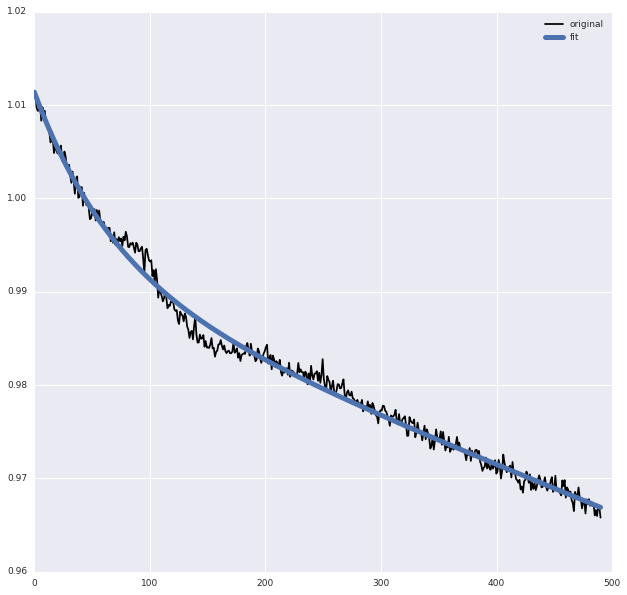

In [64]:
popt_odor, pcov = curve_fit(func, x, normalized_y, p0=(1, 1e-6, 1, 
                                       1e-6))

yy = func(x, *popt_odor)

#Plot fit
with sns.axes_style('darkgrid'):
    plt.plot(x, normalized_y, 'k-', markersize=2, label='original')
    plt.plot(x, yy, label='fit', linewidth=5)
    plt.legend()

### Step 3. Subtract fit from each pixel

In [54]:
corrected_trace = normalized_y - yy #temp_diff
corrected_trace = corrected_trace * background_frame1

In [55]:
background_frame_mean = np.mean(corrected_trace[50:100])
print background_frame_mean
background_frame_std = np.std(corrected_trace)
print background_frame_std
normalized_corrected_trace = (corrected_trace - background_frame_mean)/background_frame_mean
print min(normalized_corrected_trace)

1.26836721891
2.8753571228
-8.88379771711


In [56]:
smooth_window = 20
filtered_trace = smooth(normalized_corrected_trace, smooth_window, 'hanning')[smooth_window/2:-smooth_window/2]

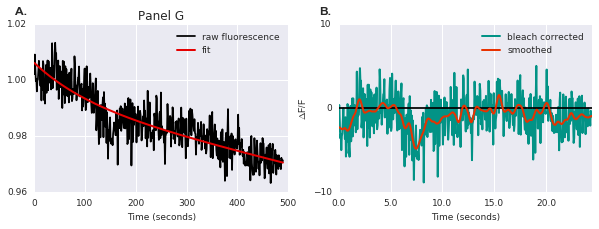

In [58]:
import plotsettings
with sns.axes_style('darkgrid'):
    fig1 = plt.figure(figsize=(10,3))
    gs = plt.GridSpec(1, 2)
    
    publishable = plotsettings.Set('Cell')
    publishable.set_figsize(n_columns = 3, n_rows = 3)
    publishable.set_figsize(3, 3, aspect_ratio = 1)
    
    ax2 = fig1.add_subplot(gs[0,0])
    plt.plot(x, normalized_y, 'k-', markersize=2, label='raw fluorescence')
    plt.plot(x, yy, color='#e50000', linewidth=2, label='fit')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.title('Panel G')
    ax2.locator_params(axis='y', nbins=6)
    
    ax3 = fig1.add_subplot(gs[0,1])
    ax3.plot(normalized_corrected_trace, color='#029386', label='bleach corrected', linewidth=2)
    fig1.canvas.draw()
    
    labels = [item.get_text() for item in ax3.get_xticklabels()]   
    A = [str(float(str(ii))/fps) for ii in labels]
    ax3.set_xticklabels(A)
    ax3.axhline(0, color='k')
    plt.xlim((0, np.size(filtered_trace,0)))
    plt.plot(filtered_trace, linewidth=2, color='#e83200',label='smoothed')

    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel(r'$\Delta$F/F')
    plt.ylim((-10, 10))
    ax3.locator_params(axis='y', nbins=3)
    
    
    publishable.panel_labels(fig = fig1, position = 'outside', case = 'upper',
                                                 prefix = '', suffix = '.', fontweight = 'bold', fontsize=12)
    
Working_Directory = '/Users/seetha/Desktop/Bleach_Correction/'
Save_Directory = os.path.join(Working_Directory, 'Traces_bleach_correction')
if not os.path.exists(Save_Directory):
    os.makedirs(Save_Directory)
fig1.savefig(Save_Directory+filesep+columnname_used+'_Bleach corrected.pdf', bbox_inches='tight')